# Import Packages

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Utility Functions

In [38]:
def plotSeries(time, series, format="-", start = 0, end = None, title=None, xlabel=None, ylabel=None, legend=None):    
    plt.figure(figsize=(20, 8))
    if type(series) is tuple:
        for _ in series:
            plt.plot(time[start:end], _[start:end], format)
    else:
        plt.plot(time[start:end], series[start:end], format)    
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
def trend(time, slope=0 ):
    return slope* time

In [6]:
def seasonalPattern(seasonTime):
    return np.where(seasonTime < 0.4, np.cos(seasonTime * 2 * np.pi), 1/np.exp(3*seasonTime))

In [7]:
def seasonality(time, period, amplitude=1, phase=0):
    seasonTime = ((time + phase) % period) / period
    return amplitude * seasonalPattern(seasonTime)

In [8]:
def noise(time, noiseLevel = 1, seed=99):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noiseLevel

In [9]:
def windowDataset(series, windowSize, batchSize, shuffleBuffer):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series) # Generate a TF Dataset from the series values
    dataset = dataset.window(windowSize + 1, shift=1, drop_remainder = True)  # Window the data but only take those with the specified size
    dataset = dataset.flat_map(lambda window: window.batch(windowSize + 1)) # Flatten the windows by putting its elements in a single batch
    dataset = dataset.shuffle(shuffleBuffer).map(lambda window: (window[:-1], window[-1])) # Create tuples with features and labels
    dataset = dataset.batch(batchSize).prefetch(1) # Shuffle the windows
    return dataset

# The Series

In [10]:
time = np.arange(4*365 + 1, dtype="float32")
baseline = 10
amplitude = 40
noiseLevel = 5
slope = 0.05

In [11]:
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude = amplitude)
series+= noise(time, noiseLevel)

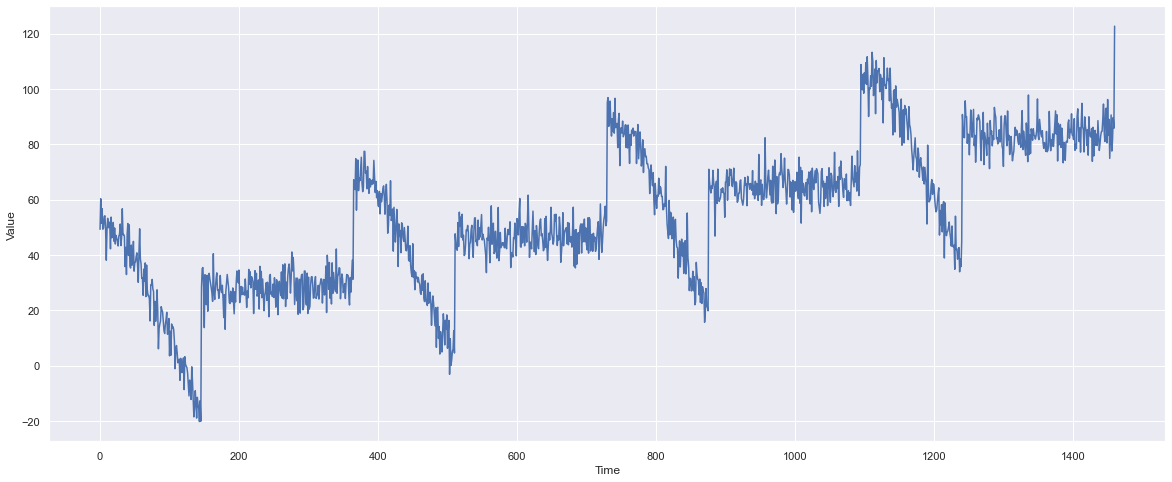

In [12]:
plotSeries(time, series)
plt.show()

## The Split

In [13]:
splitTime = 1000
timeTrain = time[:splitTime]
xTrain = series[:splitTime]
timeValid = time[splitTime:]
xValid = series[splitTime:]

# Setting The Field

In [14]:
windowSize = 20
batchSize = 32
shuffleBufferSize = 1000

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [16]:
trainSet = windowDataset(xTrain, windowSize, batchSize, shuffleBufferSize)

# The Model

In [23]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size = 5,
                           strides=1, padding="causal",
                           activation="relu",
                           input_shape=[windowSize, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 32)            192       
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
_________________________________________________________________


## Tuning Learning Rate

In [25]:
#Initialize with Dummy weights
initWeights = model.get_weights()


In [26]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
# earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [27]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [28]:
history = model.fit(trainSet, epochs=100, callbacks=[lrSchedule])

Epoch 1/100
31/31 [==============================] - 5s 21ms/step - loss: 87.3946 - mae: 87.8942
Epoch 2/100
31/31 [==============================] - 1s 20ms/step - loss: 85.1544 - mae: 85.6540
Epoch 3/100
31/31 [==============================] - 1s 20ms/step - loss: 82.9436 - mae: 83.4430
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 80.7751 - mae: 81.2746
Epoch 5/100
31/31 [==============================] - 1s 20ms/step - loss: 78.6057 - mae: 79.1052: 0s - loss: 80.7738 - mae:
Epoch 6/100
31/31 [==============================] - 1s 19ms/step - loss: 76.3533 - mae: 76.8527
Epoch 7/100
31/31 [==============================] - 1s 19ms/step - loss: 73.9807 - mae: 74.4800
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 71.4519 - mae: 71.9513
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 68.7454 - mae: 69.2449
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 65.8361 - mae: 66.3354
Ep

31/31 [==============================] - 1s 20ms/step - loss: 7.2901 - mae: 7.7739
Epoch 85/100
31/31 [==============================] - 1s 20ms/step - loss: 5.6858 - mae: 6.1668
Epoch 86/100
31/31 [==============================] - 1s 20ms/step - loss: 8.3628 - mae: 8.8493
Epoch 87/100
31/31 [==============================] - 1s 20ms/step - loss: 8.5739 - mae: 9.0634
Epoch 88/100
31/31 [==============================] - 1s 19ms/step - loss: 8.1107 - mae: 8.5987
Epoch 89/100
31/31 [==============================] - 1s 19ms/step - loss: 6.7242 - mae: 7.2126
Epoch 90/100
31/31 [==============================] - 1s 20ms/step - loss: 7.3345 - mae: 7.8193
Epoch 91/100
31/31 [==============================] - 1s 19ms/step - loss: 6.0345 - mae: 6.5145
Epoch 92/100
31/31 [==============================] - 1s 19ms/step - loss: 7.7178 - mae: 8.2048
Epoch 93/100
31/31 [==============================] - 1s 19ms/step - loss: 7.7489 - mae: 8.2382
Epoch 94/100
31/31 [==============================] -

(1e-08, 0.001, 0.0, 30.0)

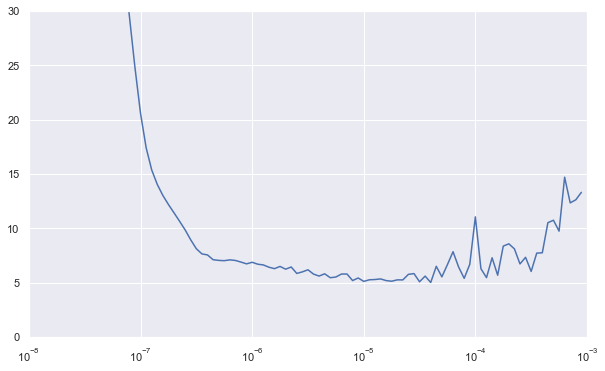

In [32]:
plt.figure(figsize=(10, 6))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 30])

In [33]:
# Reset states generated by Keras
tf.keras.backend.clear_session()
# Reset the weights
model.set_weights(initWeights)

## Model after Tuning LR

In [34]:
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [35]:
history = model.fit(trainSet, epochs=500, callbacks=[earlyStop])

Epoch 1/500
31/31 [==============================] - 5s 20ms/step - loss: 27.2908 - mae: 27.7861
Epoch 2/500
31/31 [==============================] - 1s 20ms/step - loss: 8.3938 - mae: 8.8800
Epoch 3/500
31/31 [==============================] - 1s 19ms/step - loss: 6.6639 - mae: 7.1455
Epoch 4/500
31/31 [==============================] - 1s 19ms/step - loss: 6.4237 - mae: 6.9071
Epoch 5/500
31/31 [==============================] - 1s 20ms/step - loss: 6.0104 - mae: 6.4918
Epoch 6/500
31/31 [==============================] - 1s 19ms/step - loss: 5.9436 - mae: 6.4274
Epoch 7/500
31/31 [==============================] - 1s 20ms/step - loss: 5.6671 - mae: 6.1485
Epoch 8/500
31/31 [==============================] - 1s 20ms/step - loss: 5.5469 - mae: 6.0276
Epoch 9/500
31/31 [==============================] - 1s 19ms/step - loss: 6.3806 - mae: 6.8592
Epoch 10/500
31/31 [==============================] - 1s 20ms/step - loss: 5.7271 - mae: 6.2050
Epoch 11/500
31/31 [===========================

31/31 [==============================] - 1s 19ms/step - loss: 4.4641 - mae: 4.9423
Epoch 87/500
31/31 [==============================] - 1s 20ms/step - loss: 4.4089 - mae: 4.8854
Epoch 88/500
31/31 [==============================] - 1s 19ms/step - loss: 4.5014 - mae: 4.9814
Epoch 89/500
31/31 [==============================] - 1s 20ms/step - loss: 4.3189 - mae: 4.7964
Epoch 90/500
31/31 [==============================] - 1s 20ms/step - loss: 4.2572 - mae: 4.7371
Epoch 91/500
31/31 [==============================] - 1s 20ms/step - loss: 4.5182 - mae: 4.9957
Epoch 92/500
31/31 [==============================] - 1s 19ms/step - loss: 4.6596 - mae: 5.1359
Epoch 93/500
31/31 [==============================] - 1s 20ms/step - loss: 4.3686 - mae: 4.8455
Epoch 94/500
31/31 [==============================] - 1s 20ms/step - loss: 4.3306 - mae: 4.8038
Epoch 95/500
31/31 [==============================] - 1s 20ms/step - loss: 4.2443 - mae: 4.7199
Epoch 96/500
31/31 [==============================] -

31/31 [==============================] - 1s 19ms/step - loss: 4.3892 - mae: 4.8646
Epoch 170/500
31/31 [==============================] - 1s 19ms/step - loss: 4.1578 - mae: 4.6327
Epoch 171/500
31/31 [==============================] - 1s 19ms/step - loss: 3.9928 - mae: 4.4657
Epoch 172/500
31/31 [==============================] - 1s 21ms/step - loss: 4.2078 - mae: 4.6817
Epoch 173/500
31/31 [==============================] - 1s 21ms/step - loss: 4.3529 - mae: 4.8283
Epoch 174/500
31/31 [==============================] - 1s 20ms/step - loss: 4.1313 - mae: 4.6034
Epoch 175/500
31/31 [==============================] - 1s 19ms/step - loss: 4.0656 - mae: 4.5370
Epoch 176/500
31/31 [==============================] - 1s 21ms/step - loss: 4.3398 - mae: 4.8182
Epoch 177/500
31/31 [==============================] - 1s 21ms/step - loss: 4.2634 - mae: 4.7365
Epoch 178/500
31/31 [==============================] - 1s 21ms/step - loss: 4.2084 - mae: 4.6818
Epoch 179/500
31/31 [=======================

31/31 [==============================] - 1s 20ms/step - loss: 3.9730 - mae: 4.4476
Epoch 254/500
31/31 [==============================] - 1s 20ms/step - loss: 3.9957 - mae: 4.4704: 0s - loss: 3.8361 - mae:
Epoch 255/500
31/31 [==============================] - 1s 20ms/step - loss: 4.1263 - mae: 4.6038
Epoch 256/500
31/31 [==============================] - 1s 20ms/step - loss: 3.9773 - mae: 4.4499
Epoch 257/500
31/31 [==============================] - 1s 20ms/step - loss: 4.0402 - mae: 4.5129
Epoch 258/500
31/31 [==============================] - 1s 20ms/step - loss: 4.2097 - mae: 4.6820
Epoch 259/500
31/31 [==============================] - 1s 19ms/step - loss: 4.4183 - mae: 4.8968
Epoch 260/500
31/31 [==============================] - 1s 20ms/step - loss: 4.0668 - mae: 4.5436
Epoch 261/500
31/31 [==============================] - 1s 19ms/step - loss: 3.9412 - mae: 4.4160
Epoch 262/500
31/31 [==============================] - 1s 19ms/step - loss: 4.0854 - mae: 4.5594
Epoch 263/500
31/3

In [47]:
def modelForecast(model, series, windowSize, batchSize):
    series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(windowSize, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(windowSize))
    dataset = dataset.batch(batchSize).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [48]:
forecastSeries = series[splitTime - windowSize:-1]
forecast = modelForecast(model, forecastSeries, windowSize, batchSize)
results = forecast.squeeze()

In [49]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(xValid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(xValid, results).numpy())

47.75752
5.002814


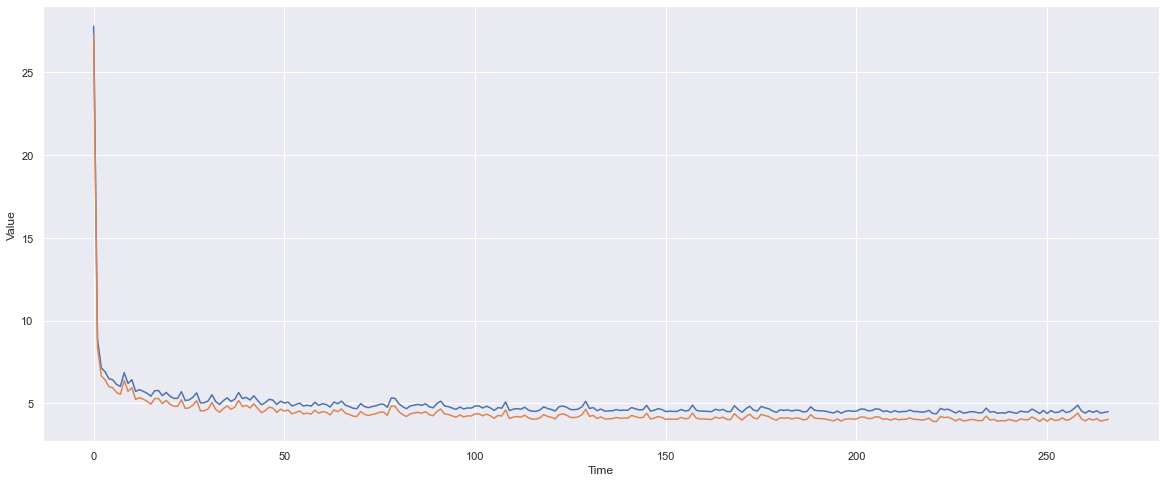

In [39]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) 

plotSeries(
    time=epochs, 
    series=(mae, loss), 
    title='MAE and Loss', 
    xlabel='Epochs',
    legend=['MAE', 'Loss']
    )